In [1]:
#importing libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, confusion_matrix

In [2]:
#generating GRB peak with poisson noise


def gen_signal(N, x0, w, A, bkg, peak=False):
    x = np.arange(N)
    y = np.ones(N) * bkg 
    
    if peak:
        y_peak = np.exp(-(x-x0)/w) * A
        y_peak[:x0] = 0
        y += y_peak
        
    y = np.random.poisson(y)

    return x, y

In [3]:
#random constant vales

#Number of data
N_data = 10000
df = pd.DataFrame(columns=["x0", "w", "A", "bkg", "GRB"], index=range(N_data))

for i in range(N_data):
    df["x0"].loc[i] = np.random.randint(10, 50)
    df["w"].loc[i] = np.random.uniform(10, 20)
    df["A"].loc[i] = np.random.uniform(10, 20)
    df["bkg"].loc[i] = np.random.uniform(7,10)
    df["GRB"].loc[i] = [True, False][np.random.randint(2)]
    
df

,x0,w,A,bkg,GRB
0,13,11.01568,17.772465,9.490901,True
1,23,13.484694,10.042378,7.859032,True
2,15,11.562721,17.063346,7.846748,True
3,45,15.766455,12.205549,7.678365,False
4,24,13.82673,12.89318,9.046331,True
...,...,...,...,...,...
9995,31,14.873968,10.340773,7.059729,False
9996,17,17.40012,19.465079,9.087546,True
9997,46,17.93212,12.796094,8.896159,False
9998,46,18.204265,11.726503,8.091389,True


In [4]:
#generating random data

#duration of peak window
N_tu = 100

data = []
for i in range(N_data):
    data.append(gen_signal(N=N_tu, 
                           x0=df.x0.loc[i], 
                           w=df.w.loc[i], 
                           A=df.A.loc[i], 
                           bkg=df.bkg.loc[i], 
                           peak=df.GRB.loc[i])[1])

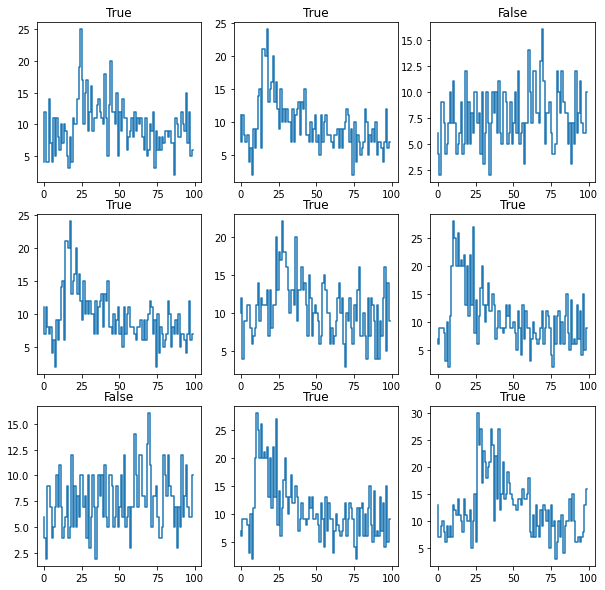

In [5]:
#plot of some curves
x = np.arange(N_tu)

fig, axs = plt.subplots(3,3,figsize=(10,10))
for i in range(3):
    for j in range(3):
        ind = (i+1)*(j+1)
        axs[i,j].set_title(df.GRB.loc[ind])
        axs[i,j].step(x, data[ind])

In [6]:
X = np.array(data).reshape(-1, int(N_tu))
y = df.GRB

#encode target labels with value between 0 and n_classes-1
le = LabelEncoder()

#fit label encoder
le.fit(y)


#transform labels to normalized encoding (True = 1, False = 0)
y = le.transform(y) 

#splits data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420)

In [7]:
model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
history = model.fit(X_train, y_train,
          validation_data = (X_test, y_test),
          batch_size=10, epochs=15)

Epoch 1/15
750/750 [==============================] - 1s 1ms/step - loss: 0.1248 - accuracy: 0.9520 - val_loss: 0.0644 - val_accuracy: 0.9812
Epoch 2/15
750/750 [==============================] - 1s 1ms/step - loss: 0.0415 - accuracy: 0.9865 - val_loss: 0.0344 - val_accuracy: 0.9900
Epoch 3/15
750/750 [==============================] - 1s 2ms/step - loss: 0.0317 - accuracy: 0.9877 - val_loss: 0.0222 - val_accuracy: 0.9928
Epoch 4/15
750/750 [==============================] - 1s 1ms/step - loss: 0.0242 - accuracy: 0.9927 - val_loss: 0.0382 - val_accuracy: 0.9872
Epoch 5/15
750/750 [==============================] - 1s 1ms/step - loss: 0.0240 - accuracy: 0.9911 - val_loss: 0.0169 - val_accuracy: 0.9956
Epoch 6/15
750/750 [==============================] - 1s 1ms/step - loss: 0.0141 - accuracy: 0.9947 - val_loss: 0.0247 - val_accuracy: 0.9920
Epoch 7/15
750/750 [==============================] - 1s 1ms/step - loss: 0.0182 - accuracy: 0.9935 - val_loss: 0.0171 - val_accuracy: 0.9964
Epoch 

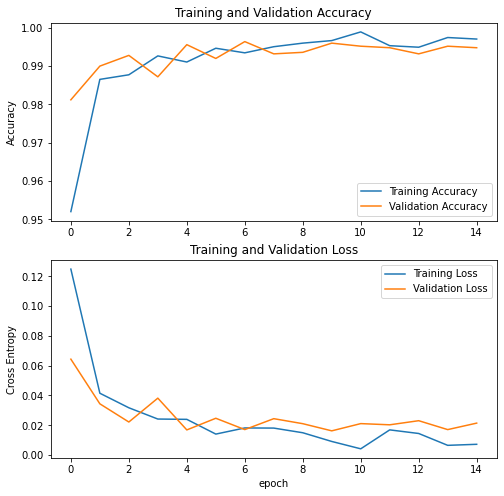

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Number of falsely identified: 13


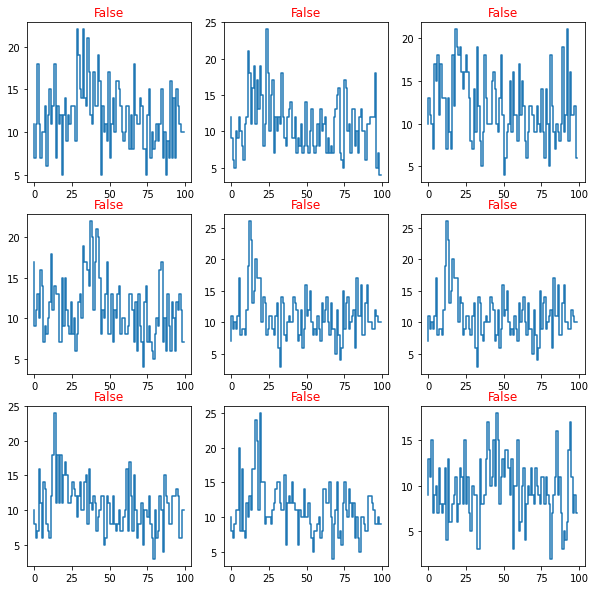

In [10]:
#predicting 
y_pred = model.predict(X_test).reshape(-1)

#(True = 1, False = 0)
threshold = 0.5
y_pred = np.where(y_pred <= threshold, 0, 1)

colors = {True : "green", False : "red"}

#index of falsely identified
indices = np.nonzero(y_pred != y_test)[0]
print('Number of falsely identified:',len(indices))

#example of falsely identified
fig, axs = plt.subplots(3,3,figsize=(10,10))
for i in range(3):
    for j in range(3):
        ind = np.random.choice(indices)
        color = colors[y_pred[ind] == y_test[ind]]
        axs[i,j].set_title(bool(y_pred[ind]), color=color)
        axs[i,j].step(x, X_test[ind])


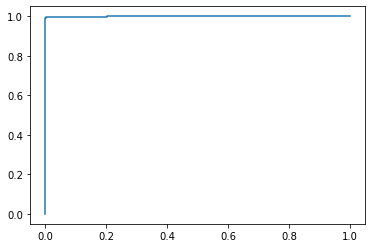

In [11]:
#ROC curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras)

True Negatives:  1214
False Positives:  0
False Negatives:  13
True Positives:  1273
Total:  1286


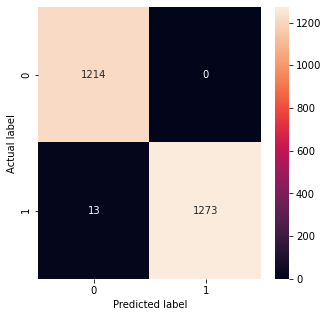

In [12]:
#heatmap of success

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions >= p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total: ', np.sum(cm[1]))
plot_cm(y_test, y_pred_keras)